In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import Laser.fresnel_propag as prop
from Laser.misc import gauss2D
import Laser.zernike as zern

# Example 1: Propagation through an optical setup with a hole

## Laser parameters

In [3]:
lam = 8e-7 # Wavelength (in m)
k = 2*np.pi/lam # Wave vector
fwhm = 0.07 # Input full-width at half-maximum

# Focusing elements (lengths in m)
f1 = 2.034 # Off-axis parabola
f2 = 0.825 # Spherical mirror
f3 = 30e-3 # Collimating lens
f4 = 0.1 # Imaging lens

# Propagation distances
z1 = f1 + 1.6
z2 = 1.33
z3 = 1.148337292 + f3
z4 = 0.2
z5 = f4

## Simulation parameters

In [4]:
L1 = 0.2 # Input plane dimension (in m)
L2 = L1*(z1-f1)/f1 # keep beam size to box size ratio constant
L3 = L1*(z1-f1+z2)/f1
L4 = L3*f3/(z3-f3)
L5 = L4
L6 = 10e-4 # Output plane dimension (in m)

N = 501 # Number of transverse points (odd to have a pixel at transverse axis = 0)

# Construct axes
x1 = np.linspace(0, L1, num=N) - L1/2 # Input plane transverse axis
x2 = np.linspace(0, L2, num=N) - L2/2
x3 = np.linspace(0, L3, num=N) - L3/2
x4 = np.linspace(0, L4, num=N) - L4/2
x5 = np.linspace(0, L5, num=N) - L5/2 
x6 = np.linspace(0, L6, num=N) - L6/2 # Output plane transverse axis

# Build 2D trasnverse axes
X1, Y1 = np.meshgrid(x1,x1)
X2, Y2 = np.meshgrid(x2,x2)
X3, Y3 = np.meshgrid(x3,x3)
X4, Y4 = np.meshgrid(x4,x4)
# The fresnel_propag module needs a 2D input field,
# to just have a 1D simulation, do "np.meshgrid(x1,0)",
# and the result of "prop.prop_two_steps" below can be flattened

## Propagation

In [5]:
%%time
# 2 sec with 500 x 500 input array

"""
Change this value to "True" to add a hole in an optic
"""
with_hole = True

# Define input electric field
u1 = gauss2D(X1, Y1, fwhm, fwhm, order=6) # 6th order super-Gaussian beam

# Add perfect lens (focal length f1) to focus the beam
u1 = u1*np.exp( -1j * k / 2 / f1 * ( X1**2 + Y1**2 ) )
# Propagate the input field
u2 = prop.prop_two_steps(u1, L1, -L2, lam, z1) # "-L2" sign because the beam flips through the focus

# Add a hole in the beam
if with_hole:
    u2[np.sqrt(X2**2 + Y2**2)<=0.01] = 0

# Propagate again
u3 = prop.prop_two_steps(u2, L2, L3, lam, z2)

# Lens and propagation again
u3 = u3*np.exp( -1j * k / 2 / f2 * ( X3**2 + Y3**2 ) )
u4 = prop.prop_two_steps(u3, L3, -L4, lam, z3)

# And again
u4 = u4*np.exp( -1j * k / 2 / f3 * ( X4**2 + Y4**2 ) )
u5 = prop.prop_two_steps(u4, L4, L5, lam, z4)

# And again
u5 = u5*np.exp( -1j * k / 2 / f4 * ( X4**2 + Y4**2 ) ) # X4 = X5
u6 = prop.prop_two_steps(u5, L5, L6, lam, z5)

CPU times: user 1.04 s, sys: 84.4 ms, total: 1.12 s
Wall time: 1.13 s


## Display results (units in mm)

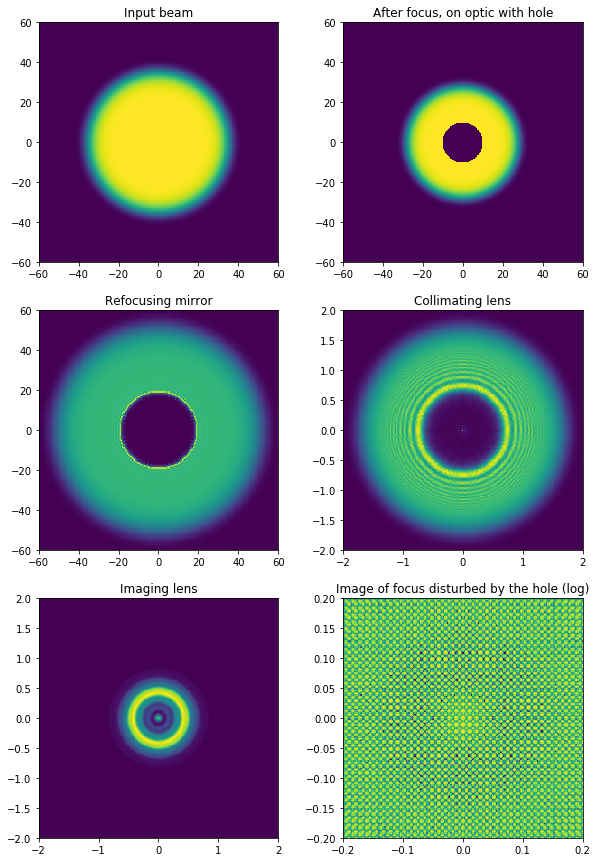

In [6]:
fig, ax = plt.subplots(3,2,figsize = (10,15))
ax[0,0].pcolormesh(x1*1e3,x1*1e3,np.abs(u1)**2)
ax[0,0].set_aspect('equal')
ax[0,0].set_title('Input beam')
ax[0,0].set_xlim(-60,60)
ax[0,0].set_ylim(-60,60)

ax[0,1].pcolormesh(x2*1e3,x2*1e3,np.abs(u2)**2)
ax[0,1].set_aspect('equal')
if with_hole:
    strtitle = 'with hole'
else:
    strtitle = 'without hole'
ax[0,1].set_title('After focus, on optic ' + strtitle)
ax[0,1].set_xlim(-60,60)
ax[0,1].set_ylim(-60,60)

ax[1,0].pcolormesh(x3*1e3,x3*1e3,np.abs(u3)**2)
ax[1,0].set_aspect('equal')
ax[1,0].set_title('Refocusing mirror')
ax[1,0].set_xlim(-60,60)
ax[1,0].set_ylim(-60,60)

ax[1,1].pcolormesh(x4*1e3,x4*1e3,np.abs(u4)**2)
ax[1,1].set_aspect('equal')
ax[1,1].set_title('Collimating lens')
ax[1,1].set_xlim(-2,2)
ax[1,1].set_ylim(-2,2)

ax[2,0].pcolormesh(x5*1e3,x5*1e3,np.abs(u5)**2)
ax[2,0].set_aspect('equal')
ax[2,0].set_title('Imaging lens')
ax[2,0].set_xlim(-2,2)
ax[2,0].set_ylim(-2,2)

"""
Change this value to display in log scale
"""
log_scale = True

i6 = np.abs(u6)**2 / np.max(np.abs(u6)**2)
logtitle = ''
if log_scale:
    ax[2,1].pcolormesh(x6*1e3,x6*1e3,np.log10(i6), vmin=-4)
    logtitle = ' (log)'
else:
    ax[2,1].pcolormesh(x6*1e3,x6*1e3,i6)
ax[2,1].set_aspect('equal')
ax[2,1].set_title('Image of focus disturbed by the hole' + logtitle)
ax[2,1].set_xlim(-0.2,0.2)
ax[2,1].set_ylim(-0.2,0.2);

# Example 2: Simulation of z-scan with non-flat wavefront

## Laser parameters

In [7]:
lam = 8e-7 # Wavelength (in m)
k = 2*np.pi/lam # Wave vector
fwhm = 0.07 # Input full-width at half-maximum

f = 2 # Focal length (in m)

## Simulation parameters

In [8]:
L1 = 0.3 # Input plane dimension (in m)
L2 = 5e-4 # Output plane dimension (in m)

Nz = 100 # Number of longitudinal positions
N = 200 # Number of transverse points

x1 = np.linspace(0, L1, num=N) - L1/2 # Input plane transverse axis
x2 = np.linspace(0, L2, num=N) - L2/2 # Output plane transverse axis
z_scan = f + np.linspace(-1e-2, 1e-2, num=Nz) # Longitudinal axis

X1, Y1 = np.meshgrid(x1,x1) # Build 2D trasnverse axes

## Propagation

In [9]:
%%time
# 100 x 200 x 200 -> about 2 sec on a standard Windows 7 desktop computer

# Define input electric field
u1 = gauss2D(X1, Y1, fwhm, fwhm, order=6) # 6th order super-Gaussian beam

# Add perfect lens (focal length f) to focus the beam
u1 = u1*np.exp( -1j * k / 2 / f * ( X1**2 + Y1**2 ) )

# Add a bit of wavefront aberration
Rho, Theta = zern.cart2pol(X1/(1.1*fwhm/2), Y1/(1.1*fwhm/2)) # Scale the FWHM by 1.1 to include the wings of the profile
astig0 = zern.zernike_map(Rho, Theta, (2,2)) # 1 lambda RMS amplitude
astig45 = zern.zernike_map(Rho, Theta, (2,-2))
coma0 = zern.zernike_map(Rho, Theta, (3,1))
coma90 = zern.zernike_map(Rho, Theta, (3,-1))
trefoil0 = zern.zernike_map(Rho, Theta, (3,3))
trefoil30 = zern.zernike_map(Rho, Theta, (3,-3))
wavefront = 0.1*coma0 - 0.1*astig45
u1 = u1*np.exp(1j * 2*np.pi * wavefront) # Add to spatial phase

# Initialise output electric field
u2 = np.complex64(np.zeros([Nz,N,N]))

# Propagate the input field for every z
for idx, z in enumerate(z_scan):
    u2[idx,:] = prop.prop_two_steps(u1, L1, L2, lam, z)

i2 = np.abs(u2)**2

CPU times: user 734 ms, sys: 41 ms, total: 775 ms
Wall time: 784 ms


## Display z-scan

In [10]:
# Extract slices
i2_hor = np.squeeze(i2[:, np.int(N/2-1), :])
i2_ver = np.squeeze(i2[:, :, np.int(N/2-1)])
i2_focus = np.squeeze(i2[np.int(Nz/2-1), :, :])

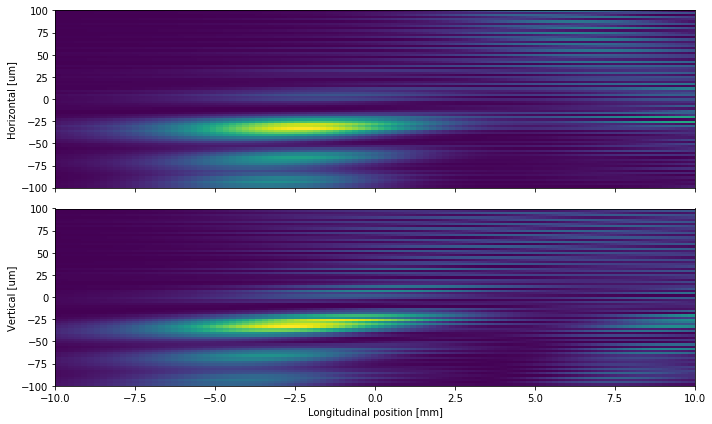

In [11]:
# Z-scan
fig, ax = plt.subplots(2,1,figsize=(10,6), sharex=True)
ax[0].pcolormesh((z_scan-f)*1e3, x2*1e6, i2_hor.T)
ax[0].set_ylabel('Horizontal [um]')
ax[0].set_ylim(-100,100)

ax[1].pcolormesh((z_scan-f)*1e3, x2*1e6, i2_ver.T)
ax[1].set_ylabel('Vertical [um]')
ax[1].set_xlabel('Longitudinal position [mm]')
ax[1].set_ylim(-100,100)
fig.tight_layout()

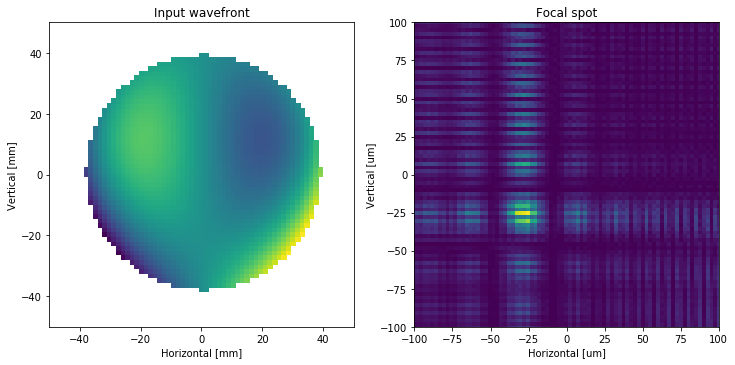

In [12]:
# Focus
wave_plot = np.ma.masked_array(wavefront, mask = Rho>1)

fig2, ax2 = plt.subplots(1,2,figsize=(12,6))

ax2[0].pcolormesh(x1*1e3,x1*1e3,wave_plot)
ax2[0].set_aspect('equal')
ax2[0].set_xlabel('Horizontal [mm]')
ax2[0].set_ylabel('Vertical [mm]')
ax2[0].set_xlim(-50,50)
ax2[0].set_ylim(-50,50)
ax2[0].set_title('Input wavefront')

ax2[1].pcolormesh(x2*1e6,x2*1e6,i2_focus)
ax2[1].set_aspect('equal')
ax2[1].set_xlabel('Horizontal [um]')
ax2[1].set_ylabel('Vertical [um]')
ax2[1].set_xlim(-100,100)
ax2[1].set_ylim(-100,100)
ax2[1].set_title('Focal spot');